In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegressionCV

# Data leakage

Data leakage may occur when you improperly handle the separation of training and testing data.
If your model has access to information it should not have at training time, the estimated performance may be overly optimistic, and the model will likely fail to generalize to new data.

This notebook provides a simple example of the potential impact of such errors. We will demonstrate how using feature selection methods before performing a train/test split produces spurious correlations that are highly misleading.

In this notebook, I will showcase an example of classification problem, as the resulting metrics are a lot more intuitive than those for regression. However, none of the problematics highlighted are exclusive to classification tasks or to simple models.

## Sample random data

In [2]:
n_samples = 500
n_features = 10_000
np.random.seed(42)
input_features = np.random.normal(size=(n_samples, n_features))
labels = np.random.binomial(n=1, p=0.5, size=n_samples)
dataset = pd.DataFrame(np.hstack([labels.reshape(-1, 1), input_features]), 
                       columns=["Label"] + [f"x{i}" for i in range(n_features)])

# First splitting the data, then performing feature selection

## Splitting into train and test splits

In [3]:
splits = train_test_split(dataset, test_size=0.2, random_state=42)
train_split, test_split = splits

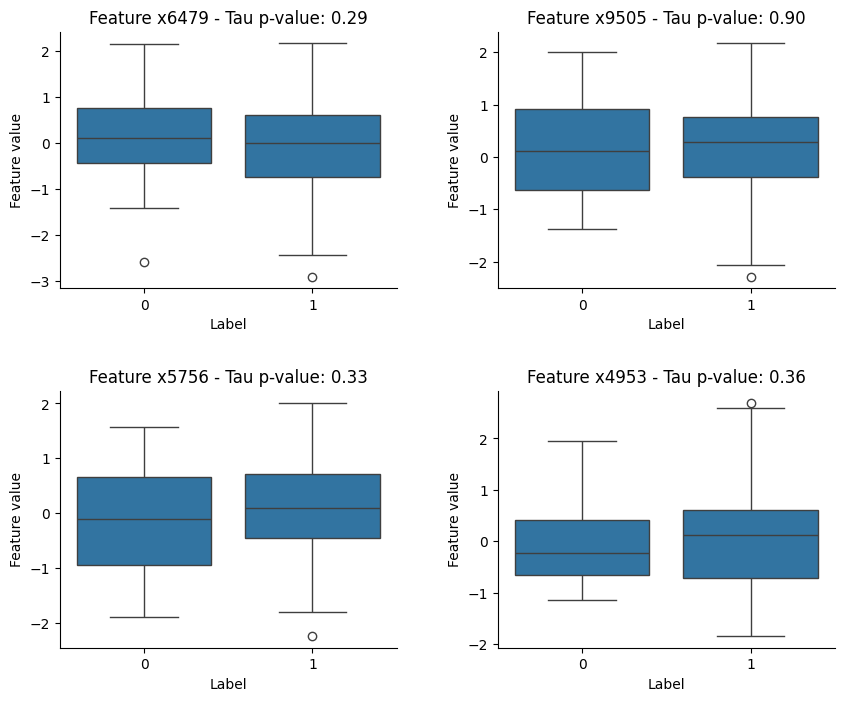

In [4]:
plot_idxs = np.random.choice(list(range(n_features)), 4, replace=False)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    idx = plot_idxs[i]
    feature_values = test_split.loc[:, f"x{idx}"].values
    targets = test_split.loc[:, "Label"].values.astype(int)
    tau = kendalltau(feature_values, targets)
    sns.boxplot(x=targets, y=feature_values, ax=ax)
    ax.set_ylabel("Feature value")
    ax.set_xlabel("Label")
    ax.set_title(f"Feature x{idx} - Tau p-value: {tau.pvalue:.2f}")
    sns.despine()

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

## Feature selection

For convenience, we will use scikit-learn's implementation of univariate feature selection.

In [5]:
input_features = train_split.drop("Label", axis=1)
training_labels = train_split["Label"]
feature_selector = SelectKBest(f_classif, k=4)
feature_selector.fit(input_features, training_labels)
selected_features = feature_selector.get_feature_names_out().tolist()

In [6]:
selected_features

['x2471', 'x4014', 'x6075', 'x9324']

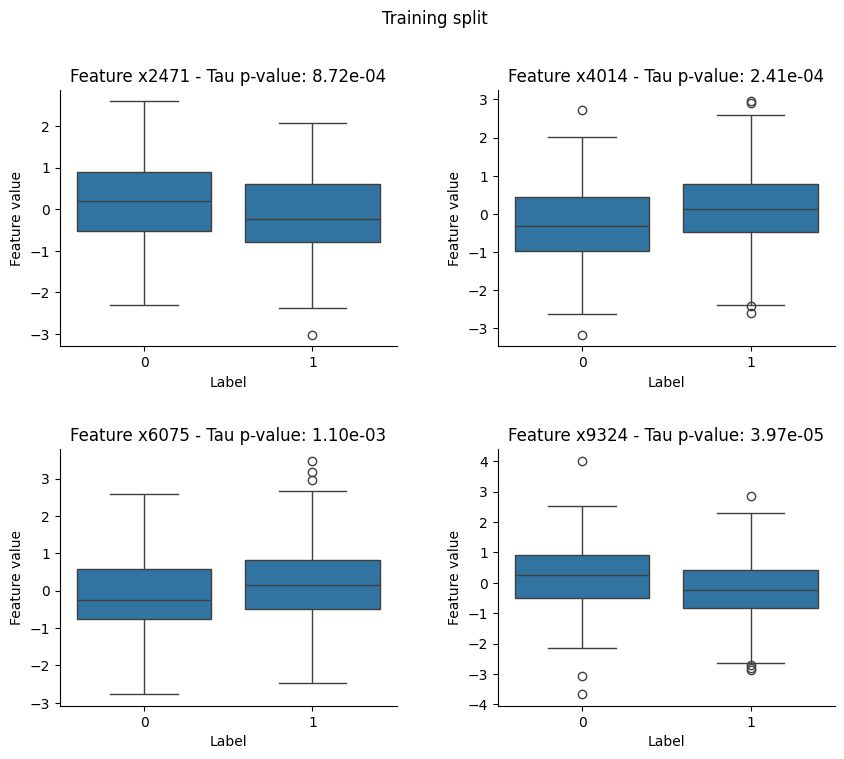

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    feature = selected_features[i]
    feature_values = train_split.loc[:, feature].values
    targets = train_split.loc[:, "Label"].values.astype(int)
    tau = kendalltau(feature_values, targets)
    sns.boxplot(x=targets, y=feature_values, ax=ax)
    ax.set_ylabel("Feature value")
    ax.set_xlabel("Label")
    ax.set_title(f"Feature {feature} - Tau p-value: {tau.pvalue:.2e}")
    sns.despine()

fig.suptitle("Training split")
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

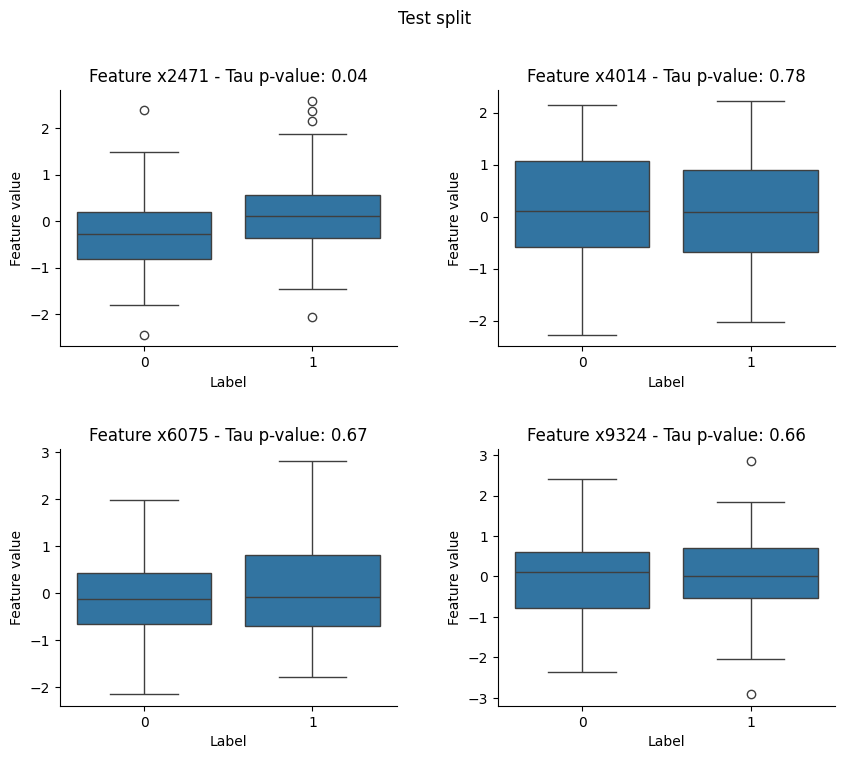

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    feature = selected_features[i]
    feature_values = test_split.loc[:, feature].values
    targets = test_split.loc[:, "Label"].values.astype(int)
    tau = kendalltau(feature_values, targets)
    sns.boxplot(x=targets, y=feature_values, ax=ax)
    ax.set_ylabel("Feature value")
    ax.set_xlabel("Label")
    ax.set_title(f"Feature {feature} - Tau p-value: {tau.pvalue:.2f}")
    sns.despine()

fig.suptitle("Test split")
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

## Train a logistic regression model

In [9]:
clf = LogisticRegressionCV(cv=5, random_state=42).fit(train_split[selected_features], train_split["Label"])
test_accuracy = clf.score(test_split[selected_features], test_split["Label"])
print(f"Accuracy on the test set: {test_accuracy:.1%}")

Accuracy on the test set: 46.0%


A bit worse than flipping a coin. This is not unexpected, as our model was trained to recognize spurious correlations that do not apply to the full dataset.

# First perform feature selection, then split the data

Now we will explore what happens when we mess up the order of operations. We will first select the features that we keep from the data, 
then we will split the dataset and train our model.

## Feature selection

In [10]:
input_features = dataset.drop("Label", axis=1)
training_labels = dataset["Label"]
feature_selector = SelectKBest(f_classif, k=4)
feature_selector.fit(input_features, training_labels)
selected_features = feature_selector.get_feature_names_out().tolist()

filtered_dataset = dataset[["Label"] + selected_features]

## Split into train and test

In [11]:
splits = train_test_split(filtered_dataset, test_size=0.2, random_state=42)
train_split, test_split = splits

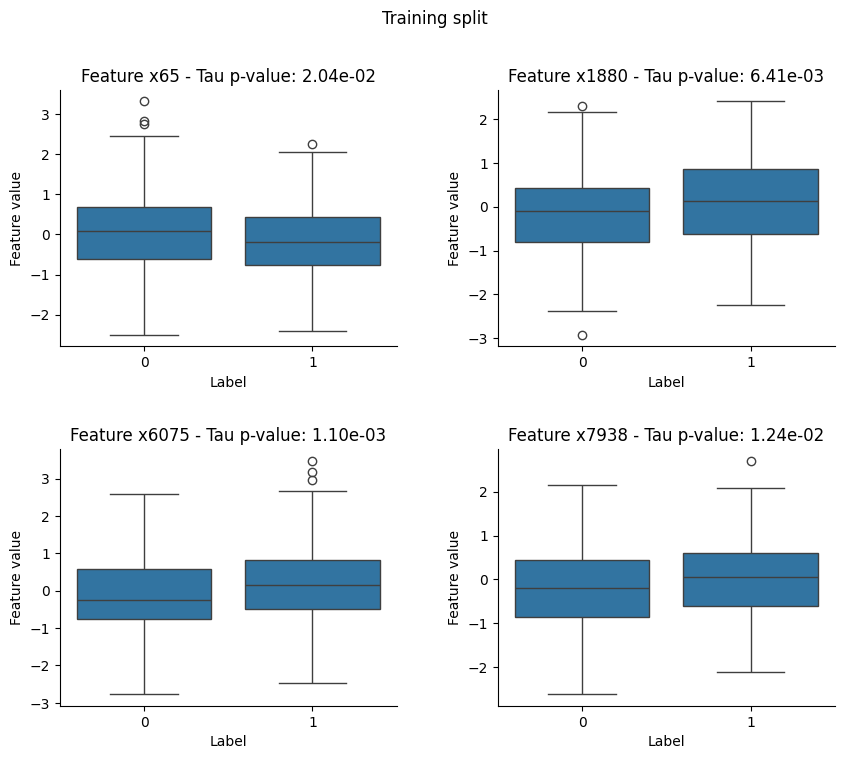

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    feature = selected_features[i]
    feature_values = train_split.loc[:, feature].values
    targets = train_split.loc[:, "Label"].values.astype(int)
    tau = kendalltau(feature_values, targets)
    sns.boxplot(x=targets, y=feature_values, ax=ax)
    ax.set_ylabel("Feature value")
    ax.set_xlabel("Label")
    ax.set_title(f"Feature {feature} - Tau p-value: {tau.pvalue:.2e}")
    sns.despine()

fig.suptitle("Training split")
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

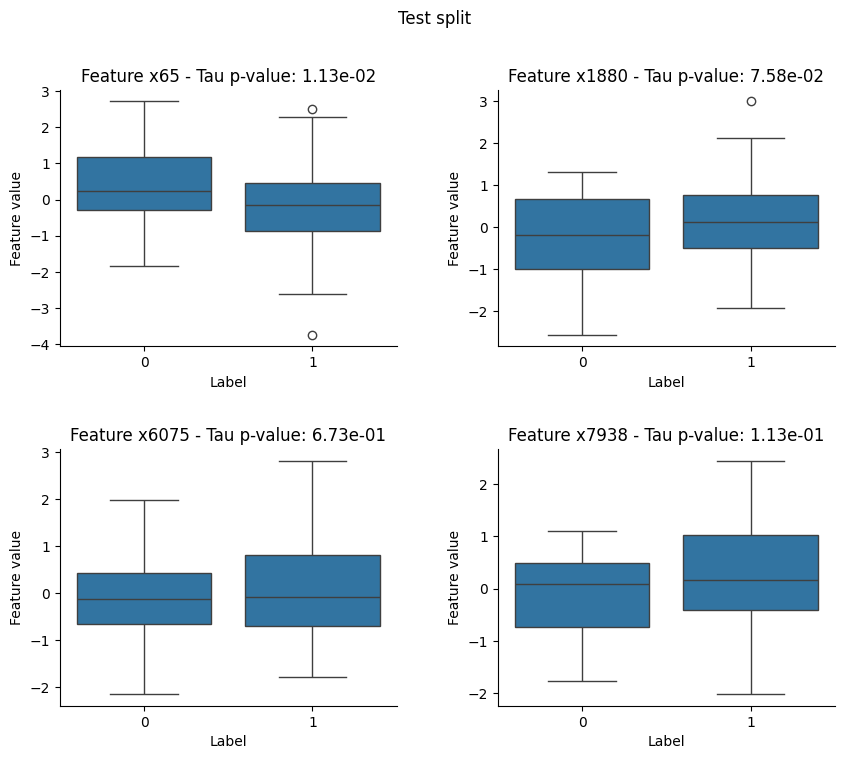

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    feature = selected_features[i]
    feature_values = test_split.loc[:, feature].values
    targets = test_split.loc[:, "Label"].values.astype(int)
    tau = kendalltau(feature_values, targets)
    sns.boxplot(x=targets, y=feature_values, ax=ax)
    ax.set_ylabel("Feature value")
    ax.set_xlabel("Label")
    ax.set_title(f"Feature {feature} - Tau p-value: {tau.pvalue:.2e}")
    sns.despine()

fig.suptitle("Test split")
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

## Train a Logistic Regression model

In [14]:
clf = LogisticRegressionCV(cv=5, random_state=42).fit(train_split[selected_features], train_split["Label"])
test_accuracy = clf.score(test_split[selected_features], test_split["Label"])
print(f"Accuracy on the test set: {test_accuracy:.1%}")

Accuracy on the test set: 68.0%


This time the results appears to be much better than chance. We have severely overestimated the performance of our model, and it will inevitably fail to generalize to new data.